# ADM-HW4-Q2-Grouping songs together!


In [439]:
!pip install yellowbrick
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [440]:
import pandas as pd
import numpy as np
import pickle
from operator import itemgetter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 2. Grouping songs together!


# 2.1 Getting your data!

loading the datasets.

In [441]:
filepath = '/content/drive/MyDrive/mehdi_data.pkl'
try:
    with open(filepath, 'rb') as f:
        datas = pickle.load(f)
except:
    !curl https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/echonest.csv --output echonest.csv
    !curl https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/features.csv --output features.csv
    !curl https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/tracks.csv --output tracks.csv
    datas = {}
    datas['echonest'] = pd.read_csv('echonest.csv')
    datas['features'] = pd.read_csv('features.csv')
    datas['tracks'] = pd.read_csv('tracks.csv')
    with open(filepath, 'wb') as f:
        pickle.dump(datas, f)


Here we breifly look at the datasets descriptions.

In [442]:
print(datas['echonest'].info())
datas['echonest'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB
None


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,metadata_artist_longitude,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,...,temporal_features_184,temporal_features_185,temporal_features_186,temporal_features_187,temporal_features_188,temporal_features_189,temporal_features_190,temporal_features_191,temporal_features_192,temporal_features_193,temporal_features_194,temporal_features_195,temporal_features_196,temporal_features_197,temporal_features_198,temporal_features_199,temporal_features_200,temporal_features_201,temporal_features_202,temporal_features_203,temporal_features_204,temporal_features_205,temporal_features_206,temporal_features_207,temporal_features_208,temporal_features_209,temporal_features_210,temporal_features_211,temporal_features_212,temporal_features_213,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
count,13129.000000,1.312900e+04,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,9770.000000,9770.000000,2.825000e+03,2.825000e+03,2.824000e+03,2.033000e+03,2.206000e+03,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,...,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000,13129.000000
mean,34031.058268,5.246876e-01,0.487290,0.537516,0.640536,0.187804,0.099174,123.080061,0.439761,39.961892,-49.984040,2.111136e+05,1.446907e+05,2.341483e+05,2.919776e+06,2.325537e+06,0.321996,0.286287,0.346769,0.000234,0.033308,0.448356,0.435871,0.365206,0.306067,0.365518,0.325732,0.332409,0.357958,0.321880,0.358277,0.301121,0.340118,0.401486,0.388409,0.294578,0.241778,0.296883,0.254248,0.262437,...,0.872021,6.858804,0.848228,2.908066,0.921906,2.175340,4.113617,0.828546,-14.794945,-13.746790,36.205622,-51.367419,-5.867554,45.499864,-2.508527,17.942374,0.063839,0.045049,0.040818,0.004679,0.963607,0.958927,5.044441,62.825004,-22.696658,-21.520480,49.906769,-59.524594,-10.883372,48.641221,-1.966002,10.745951,0.308984,0.255381,0.163876,0.068526,4.183428,4.114902,7.605432,138.932366
std,28950.422182,3.837186e-01,0.190148,0.278049,0.361430,0.158051,0.137381,35.015137,0.276028,15.554275,59.377974,3.194601e+05,2.199230e+05,4.112605e+05,1.974510e+06,1.827741e+06,0.114619,0.128304,0.133279,0.001474,0.061965,0.164809,0.166433,0.132484,0.118799,0.139493,0.124826,0.124180,0.1312

In [443]:
print(datas['features'].info())
datas['features'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB
None


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,...,tonnetz_max_04,tonnetz_max_05,tonnetz_max_06,tonnetz_mean_01,tonnetz_mean_02,tonnetz_mean_03,tonnetz_mean_04,tonnetz_mean_05,tonnetz_mean_06,tonnetz_median_01,tonnetz_median_02,tonnetz_median_03,tonnetz_median_04,tonnetz_median_05,tonnetz_median_06,tonnetz_min_01,tonnetz_min_02,tonnetz_min_03,tonnetz_min_04,tonnetz_min_05,tonnetz_min_06,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
count,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,...,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000,106574.000000
mean,79442.637435,0.439999,0.199756,0.334683,0.270263,0.294806,0.315635,0.273511,0.334927,0.201939,0.285631,0.430549,0.474014,0.622666,0.593421,0.610000,0.588934,0.608178,0.595993,0.590399,0.612476,0.590769,0.607276,0.589148,0.598006,0.257083,0.251316,0.249253,0.250905,0.253644,0.244610,0.244378,0.252502,0.251147,0.243101,0.234241,0.232713,0.248578,0.245066,0.239654,...,0.318737,0.077757,0.075959,0.000391,0.004197,-0.000877,0.011858,0.002060,0.001787,0.000582,0.004056,-0.001033,0.012131,0.001921,0.002129,-0.120573,-0.115616,-0.307343,-0.299358,-0.071644,-0.076377,-0.065868,0.075085,0.028169,-0.015902,0.027289,-0.084103,0.030505,0.031576,0.099024,0.098667,0.021569,0.021880,29.464638,0.381368,0.052755,0.043576,0.002342,3.214247,0.040303
std,44704.398384,32.285524,11.120903,9.980692,19.074557,15.025603,12.176182,16.975991,15.486402,7.364308,8.175257,19.343114,22.967662,0.086195,0.083298,0.088985,0.087267,0.089667,0.090984,0.089463,0.089503,0.087707,0.093715,0.092111,0.092947,0.081508,0.073416,0.079626,0.071161,0.078324,0.072895,0.070814,0.078008,0.071696,0.078482,0.072911,0.076043,0.095316,0.086288,0.094280,...,0.100857,0.025528,0.025706,0.013213,0.015289,0.062385,0.065445,0.010362,0.010923,0.013033,0.014873,0.066039,0.068685,0.010540,0.011056,0.046688,0.046662,0.100644,0.104546,0.023887,0.025564,0.573492,0.683507,0.534369,0.537356,0.438138,0.443332,0.008109,0.008858,0.037662,0.037101,0.006076,0.006125

In [166]:
print(datas['tracks'].info())
datas['tracks'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        103045 non-null  object 
 3   album_date_released       70294 non-null   object 
 4   album_engineer            15295 non-null   object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         83149 non-null   object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            18060 non-null   object 
 10  album_tags                106574 non-null  object 
 11  album_title               105549 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                100066 non-null  o

,track_id,album_comments,album_favorites,album_id,album_listens,album_tracks,artist_comments,artist_favorites,artist_id,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
count,106574.000000,106574.000000,106574.000000,106574.000000,1.065740e+05,106574.000000,106574.000000,106574.000000,106574.000000,44544.000000,44544.000000,106574.000000,106574.000000,106574.000000,106574.000000,1.065740e+05,106574.000000,106574.000000
mean,79442.637435,0.394946,1.286927,12826.933914,3.212031e+04,19.721452,1.894702,30.041915,12036.770404,39.901626,-38.668642,263274.695048,0.031621,277.849100,3.182521,3.541310e+03,2329.353548,8.260945
std,44704.398384,2.268915,3.133035,6290.261805,1.478532e+05,39.943673,6.297679,100.511408,6881.420867,18.240860,65.237220,67623.443584,0.321993,305.518553,13.513820,1.901743e+04,8028.070647,15.243271
min,2.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1.000000,-45.878760,-157.526855,-1.000000,0.000000,0.000000,0.000000,2.000000e+00,0.000000,0.000000
25%,40820.250000,0.000000,0.000000,7793.000000,3.361000e+03,7.000000,0.000000,1.000000,6443.000000,39.271398,-79.997459,192000.000000,0.000000,149.000000,0.000000,5.990000e+02,292.000000,2.000000
50%,78983.500000,0.000000,0.000000,13374.000000,8.982000e+03,11.000000,0.000000,5.000000,12029.500000,41.387917,-73.554431,299914.000000,0.000000,216.000000,1.000000,1.314000e+03,764.000000,5.000000
75%,119422.750000,0.000000,1.000000,18203.000000,2.363500e+04,17.000000,1.000000,16.000000,18011.000000,48.856930,4.351710,320000.000000,0.000000,305.000000,3.000000,3.059000e+03,2018.000000,9.000000
max,155320.000000,53.000000,61.000000,22940.000000,3.564243e+06,652.000000,79.000000,963.000000,24357.000000,67.286005,175.277000,448000.000000,37.000000,18350.000000,1482.000000,3.293557e+06,543252.000000,255.000000


We should use the 'track_id' column to merge the datasets. Meanwhile we compute the number of NA columns.

Text(0, 0.5, 'Number of columns')

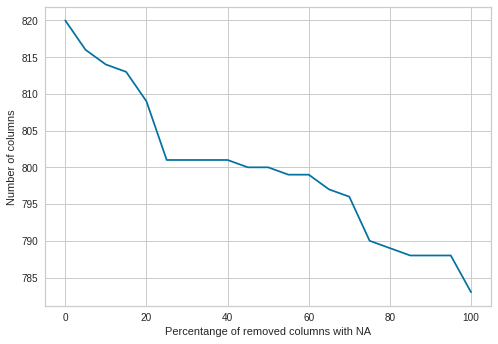

In [359]:
final_dataset = datas['echonest'].merge(datas['tracks'], on='track_id').merge(datas['features'], on='track_id')
n_columns = [final_dataset.dropna(axis=1, thresh=final_dataset.shape[0]*0.01*i).shape[1] for i in range(0, 105, 5)]
plt.plot(range(0, 105, 5), n_columns)
plt.xlabel('Percentange of removed columns with NA')
plt.ylabel('Number of columns')

Now we replace the NA cells by mean(for numeric values) and put a '' for string values.

In [444]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
def fill_nan(df):
    '''
    Fill the NA values in df by mean for numeric and '' for strings.
    '''
    for i in df.columns:
        if is_numeric_dtype(df[i]) == True:
            df[i] = df[i].fillna(df[i].mean())
        elif is_string_dtype(df[i]) == True:
            df[i] = df[i].fillna('')
    return df

clustering_data = {}
clustering_data['echonest'] = fill_nan(datas['echonest'])
clustering_data['tracks'] = fill_nan(datas['tracks'])
clustering_data['features'] = fill_nan(datas['features'])

# 2.2 Choose your features (variables)!

We used the PCA method for reduce the dimensionality of data.

In [369]:
def categorical_to_numerical(df):
    '''
    Consume a pandas dataframe and every categorical column to numerical.
    
    categorical_to_numerical: pd.DataFrame -> pd.DataFrame
    '''
    new_df = df.copy()
    categorical_columns = new_df.select_dtypes('object').columns
    for col in categorical_columns:
        new_df[col] = pd.factorize(new_df[col])[0]
    return new_df

def standard_scale(df):
    '''
    Consume a pandas dataframe and scale every columns using 
    sklearn.preprocessing.StandardScaler
    
    standard_scale: pd.DataFrame -> pd.DataFrame
    '''
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.iloc[:, 1:].values)
    new_df = pd.DataFrame(scaled_data)
    final_df = pd.concat([df.iloc[:, 0], new_df], axis = 1)
    final_df.columns = df.columns
    return final_df

Before using the PCA we should to some preprocessing. With the help of 'categorical_to_numerical' and 'standard_scale' functions, we change the objects to numerical and then we scale the values. You can see the result for echonest dataset.

In [370]:
echonest_for_pca = standard_scale(categorical_to_numerical(clustering_data['echonest']))
echonest_for_pca.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,...,temporal_features_184,temporal_features_185,temporal_features_186,temporal_features_187,temporal_features_188,temporal_features_189,temporal_features_190,temporal_features_191,temporal_features_192,temporal_features_193,temporal_features_194,temporal_features_195,temporal_features_196,temporal_features_197,temporal_features_198,temporal_features_199,temporal_features_200,temporal_features_201,temporal_features_202,temporal_features_203,temporal_features_204,temporal_features_205,temporal_features_206,temporal_features_207,temporal_features_208,temporal_features_209,temporal_features_210,temporal_features_211,temporal_features_212,temporal_features_213,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,-0.281499,0.991915,0.348732,-1.742887,-0.064267,0.437749,1.223573,0.495983,-0.403115,-0.447544,-0.542858,-0.730277,-0.648952,-1.438266,-1.739574,-3.928683e-16,0.000000,3.052274e-16,0.000000,6.216801e-16,0.584512,0.782963,0.447205,-0.15861,-0.537540,2.602372,0.919566,-0.082752,-0.092399,-0.481088,-0.130599,-0.224785,-0.178109,-0.586609,-0.732929,0.149177,0.245649,2.655370,0.828443,...,-0.447666,-0.443332,-0.535228,-0.468007,-0.595835,-0.520372,-0.413939,0.268249,0.338877,0.355029,0.367960,-0.789227,0.397938,0.916981,-0.035972,-0.173525,-0.321585,-0.416875,-0.016683,-1.044048,-0.293799,-0.292003,-0.771840,-0.383267,0.115431,0.150329,-0.023316,-0.189174,0.214204,0.283229,-0.015394,-0.196498,-0.541629,-0.746474,-0.039156,-0.406800,-0.101961,-0.101075,0.886203,0.549691
1,3,-0.391656,0.217484,1.006860,-1.767172,-0.518358,2.639805,0.110726,-0.617788,-0.403115,-0.447544,-0.542858,-0.730277,-0.648952,-1.438266,-1.739574,-3.928683e-16,0.000000,3.052274e-16,0.000000,6.216801e-16,0.584512,0.782963,0.447205,-0.15861,-0.537540,0.522280,0.610138,0.589480,0.713942,-0.150159,0.326192,0.701000,2.969636,1.126624,0.253437,1.499448,0.513654,0.463686,0.572093,...,0.083073,-0.359131,-0.518703,-0.431708,-0.624032,-0.386971,-0.437530,0.119337,0.336544,0.333389,-0.364643,-0.789227,0.016159,0.755923,0.342946,-0.283952,-0.124264,0.019168,-0.016512,-1.044048,-0.242444,-0.240644,-0.622136,-0.343546,0.327747,0.205561,-0.806094,-0.189174,0.216360,0.285267,0.224575,-0.092590,-0.360448,-0.411759,-0.023682,-0.402225,0.382370,0.383292,1.407079,0.827430
2,5,-1.253885,1.358338,0.589683,-1.770366,1.172705,0.185049,-0.651745,0.659017,-0.403115,-0.447544,-0.542858,-0.730277,-0.648952,-1.438266,-1.739574,-3.928683e-16,0.000000,3.052274e-16,0.000000,6.216801e-16,0.584512,0.782963,0.447205,-0.15861,-0.537540,0.605188,1.708388,0.181548,0.327181,-0.030244,0.615368,0.818482,0.229910,1.544675,1.244655,1.074195,0.823395,0.485869,1.740413,...,-0.648649,-0.146853,-0.655806,-0.530558,-0.797555,-0.557665,-0.480646,0.390433,-0.097335,-0.051336,-0.009377,-0.789227,-0.283958,0.629316,0.001364,-0.232480,-0.106016,0.040094,-0.016353,-1.044048,-0.259742

Now we can use PCA.

We plot the PCA explained ratio. we want to cover at least 70 percent of total variance.

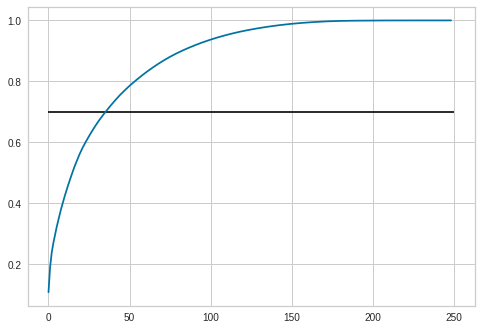

In [371]:
pca = PCA()
echonest_pca = pca.fit_transform(echonest_for_pca.iloc[:, 1:].values)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.hlines(0.7, xmin=0, xmax=250)
treshold = np.argmax(pca.explained_variance_ratio_.cumsum()>0.8)
feature_selected_echonest = \
    pd.DataFrame(echonest_pca[:, :treshold], index=echonest_for_pca['track_id'])


In [372]:
tracks_for_pca = standard_scale(categorical_to_numerical(categorical_to_numerical(clustering_data['tracks'])))
tracks_for_pca.describe()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
count,106574.000000,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05
mean,79442.637435,-4.206325e-14,-1.712010e-14,-1.633385e-13,3.943409e-14,-1.600304e-14,2.630540e-14,6.265052e-15,-1.397701e-15,1.096210e-13,4.714332e-13,9.893682e-15,-1.549347e-15,-8.509217e-14,4.453957e-14,1.526699e-14,7.993389e-16,1.624905e-13,-1.066303e-14,2.968432e-14,1.253954e-14,-1.952486e-15,-1.664551e-14,1.504417e-13,-3.457194e-15,2.096067e-14,-2.563231e-14,2.025799e-15,6.296646e-15,-1.533572e-13,-7.761943e-14,-4.221460e-15,-1.488183e-14,1.551162e-13,1.365831e-15,-3.467231e-14,3.610168e-16,7.987379e-14,-1.099201e-16,-3.918177e-15,4.965353e-15,-5.059067e-14,-2.716328e-14,2.722503e-14,1.253699e-16,-1.110511e-13,1.796347e-14,2.233244e-16,1.911183e-14,1.556976e-14,-3.422457e-14,2.611104e-13,-3.548288e-16
std,44704.398384,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,2.000000,-6.148104e-01,-1.728232e+00,-9.910015e-01,-3.111210e-01,-7.299433e-01,-2.039342e+00,-1.226190e+00,-2.172524e-01,-3.292834e-01,-4.356407e-01,-1.810687e+00,-5.187692e-01,-4.424757e-01,-4.173613e-01,-1.821566e-01,-3.397327e-01,-9.832821e-01,-4.596480e-01,-1.558563e+00,-3.088412e-01,-1.749032e+00,-7.274089e+00,-7.335175e-01,-2.818186e+00,-6.906839e-01,-1.588093e+00,-3.363789e-01,-1.522442e+00,-1.098253e+00,-2.045351e-01,-4.808998e-01,-2.802142e+00,-3.893279e+00,-9.820514e-02,-1.756741e-01,-1.725723e+00,-2.673605e-01,-9.094387e-01,-2.355023e-01,-1.202476e+00,-9.623507e-01,-8.901396e-01,-1.171351e-01,-1.861096e-01,-1.124991e+00,-6.079160e-01,-2.901525e-01,-4.830556e-02,-5.419430e-01,-1.037780e-01,-4.406671e-01,-1.625812e+00
25%,40820.250000,-1.740691e-01,-8.558859e-01,-9.737828e-01,-3.111210e-01,-4.107625e-01,-8.002779e-01,-1.086747e+00,-1.945135e-01,-3.292834e-01,-4.356407e-01,-8.662889e-01,-3.184863e-01,-4.424757e-01,-3.497069e-01,-1.821566e-01,-3.397327e-01,-9.817777e-01,-3.008586e-01,-8.678079e-01,-2.889428e-01,-8.128840e-01,6.447103e-14,-7.3

Same here for tracks datasets

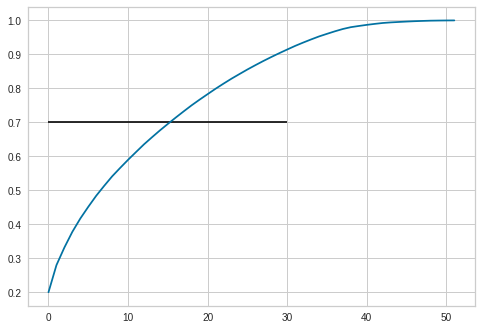

In [373]:
pca = PCA()
tracks_pca = pca.fit_transform(tracks_for_pca.iloc[:, 1:].values)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.hlines(0.7, xmin=0, xmax=30)
treshold = np.argmax(pca.explained_variance_ratio_.cumsum()>0.8)
feature_selected_tracks = \
    pd.DataFrame(tracks_pca[:, :treshold], index=tracks_for_pca['track_id'])



At the end performing the PCA for features dataset.

In [374]:
features_for_pca = standard_scale(categorical_to_numerical(categorical_to_numerical(clustering_data['features'])))
features_for_pca.describe()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,...,tonnetz_max_04,tonnetz_max_05,tonnetz_max_06,tonnetz_mean_01,tonnetz_mean_02,tonnetz_mean_03,tonnetz_mean_04,tonnetz_mean_05,tonnetz_mean_06,tonnetz_median_01,tonnetz_median_02,tonnetz_median_03,tonnetz_median_04,tonnetz_median_05,tonnetz_median_06,tonnetz_min_01,tonnetz_min_02,tonnetz_min_03,tonnetz_min_04,tonnetz_min_05,tonnetz_min_06,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
count,106574.000000,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,...,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05,1.065740e+05
mean,79442.637435,-1.493462e-17,7.474478e-20,-1.601941e-17,-9.954240e-18,-7.119310e-18,-4.105638e-17,2.151465e-17,-1.608787e-17,5.323391e-17,-7.105182e-18,1.816012e-18,6.239236e-18,1.004841e-15,-7.974075e-16,8.165932e-16,5.164625e-16,-8.208696e-17,-5.907635e-16,-7.233743e-16,-7.575287e-16,1.388935e-16,-7.752133e-16,-6.699091e-16,6.099474e-17,5.211800e-16,3.883603e-18,-2.251641e-16,1.935489e-16,-2.291659e-16,-1.635220e-16,6.958400e-16,-4.929718e-17,4.569943e-16,2.249115e-16,-5.043939e-16,3.646155e-16,-3.689746e-16,1.416166e-16,6.524107e-16,...,-5.925501e-16,-2.403401e-16,-7.949188e-16,-8.787460e-18,6.027086e-17,1.274516e-16,9.876885e-17,8.123534e-17,7.681068e-17,-4.390515e-17,1.445778e-16,3.556497e-17,-8.316932e-17,-3.126988e-17,-4.141529e-16,1.385544e-16,9.316169e-17,-5.650636e-16,5.311111e-17,-4.591434e-16,-4.077565e-16,1.616779e-18,-1.696009e-16,8.226184e-17,5.054101e-17,7.441872e-17,1.354800e-16,9.211057e-18,5.852574e-16,1.353661e-16,-4.119357e-16,3.037042e-16,-1.793676e-15,-3.372630e-17,-1.733621e-16,1.909581e-16,2.154681e-14,-4.151435e-15,-1.201151e-16,-3.974026e-17
std,44704.398384,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.0000

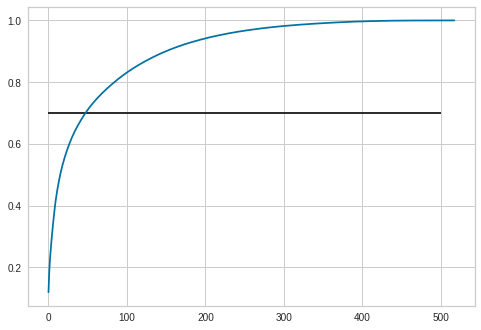

In [375]:
pca = PCA()
features_pca = pca.fit_transform(features_for_pca.iloc[:, 1:].values)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.hlines(0.7, xmin=0, xmax=500)
treshold = np.argmax(pca.explained_variance_ratio_.cumsum()>0.8)
feature_selected_features = \
    pd.DataFrame(features_pca[:, :treshold], index=features_for_pca['track_id'])

# 2.3 Clustering!

Now we implement the K-Means algorithm and merge the datasets for further clustring

In [518]:

final_dataset = feature_selected_echonest.merge(feature_selected_tracks, on='track_id').\
    merge(feature_selected_features, on='track_id')
array = final_dataset.values

def K_Means(array, k, iterations=None, tolerance=1e-2):
    iterations = iterations or array.shape[0]

    array = np.array(array)
    n_samples = array.shape[0]
    n_features = array.shape[1]

    centroids_ids = np.random.choice(n_samples, k, replace = False)
    centroids = array[centroids_ids]

    clusters = defaultdict(list)



    for i in range(iterations):
        result = []
        distances = []
        for j, sample in enumerate(array):
            d = np.linalg.norm(sample - centroids, axis=1)
            distances.append(d.min())
            cluster_id = d.argmin()
            clusters[cluster_id].append(j)
            result.append(cluster_id)

        previous_centroids = centroids
        centroids =\
            np.array(
                [array[c].mean(0) for c in itemgetter(*list(range(k)))(clusters)]
                )
        if np.linalg.norm(previous_centroids-centroids)/np.linalg.norm(previous_centroids) < tolerance:
            break

    return np.array(result), np.array(distances)


array.shape

(13129, 160)

You can see that we have around 13K rows

**The Elbow Method**

Now we use Elbow method for finding the optimal number of clusters

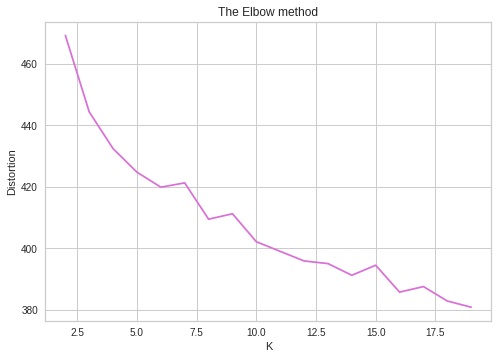

In [377]:
from scipy.spatial.distance import cdist

cost = [] 

for i in range(2, max_k): 
    clusters, distances = K_Means(array, i, 10)
    
    cost.append(sum(distances**2)/array.shape[0])

x = list(range(2,20)) 

plt.plot(x, cost, color = "orchid")
plt.title("The Elbow method")
plt.xlabel("K")
plt.ylabel("Distortion")
plt.show()


It seems that K=6 is an optimal option.


**The Silhouette Method**

We also use the Silhouette Method for finding the optimal number of clusters.

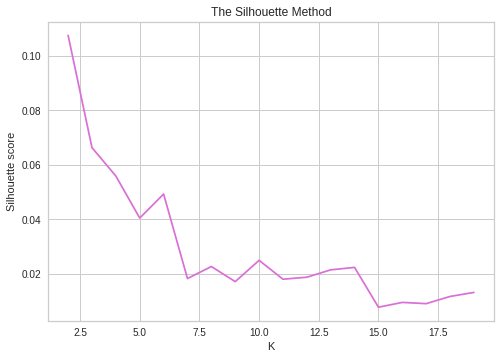

In [378]:
from sklearn.metrics import silhouette_score
sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, max_k):
    clusters, distances = K_Means(array, k, 10)
    sil.append(silhouette_score(array, clusters, metric = 'euclidean'))

plt.plot(x, sil, color = "orchid")
plt.title("The Silhouette Method")
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()

At the end we chose 6 because it seem that second method's result are not correct.

# 2.3.4: use the already implemented version of k-means++


We know that the differences between the two algorithm is in the initialization of the centroids.

We have used the library yellowbrick to visualize the optimal number of clusters.
The metric distortion gives us back as optimal number of cluster 6.

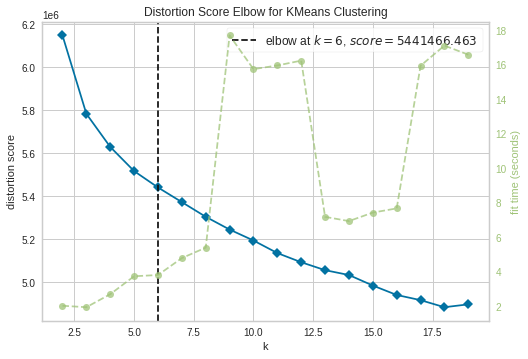

In [379]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = "distortion")
visualizer.fit(array)
visualizer.show()

And performing elbow method on kmeans++ suggest the 6.

# 2.4 Analysing your results!

To identify the genre of a song we have selected six features:
- 'track_duration'
- 'track_language_code'
- 'album_listens'
- 'album_tracks'
- 'artist_location'
- 'track_genre_top'

We have some nun-numerical features. As requested we have categorized each them in four categories through the function of pandas cut or qcut.


In [520]:
clusters, distances = K_Means(array, 6, 10)

In [521]:
columns = ['track_duration', 'track_language_code', 'album_listens', 'album_tracks', 'artist_location', 'track_genre_top']
numeric_columns = ['track_duration', 'album_listens', 'album_tracks']
final_dataset = clustering_data['echonest'].\
    merge(clustering_data['tracks'], on='track_id').\
    merge(clustering_data['features'], on='track_id').set_index('track_id')

pivot = pd.DataFrame(pd.qcut(final_dataset[numeric_columns[0]], q = 4,labels=['A', 'B', 'C', 'D']))
for i in range(1, 3):
    pivot = pivot.merge(pd.qcut(final_dataset[numeric_columns[i]], q = 4,labels=['A', 'B', 'C', 'D']), on='track_id') 
pivot = pivot.merge(final_dataset[columns[1]], on='track_id')
pivot = pivot.merge(final_dataset[columns[-1]], on='track_id')
pivot = pivot.merge(final_dataset[columns[-2]], on='track_id')

pivot['clusters'] = clusters
pivot

,track_duration,album_listens,album_tracks,track_language_code,track_genre_top,artist_location,clusters
track_id,,,,,,,
2,B,B,B,en,Hip-Hop,New Jersey,4
3,C,B,B,en,Hip-Hop,New Jersey,4
5,B,B,B,en,Hip-Hop,New Jersey,4
10,B,D,A,en,Pop,,5
134,B,B,B,en,Hip-Hop,New Jersey,3
...,...,...,...,...,...,...,...
124857,C,D,C,,,,4
124862,C,D,C,,,,5
124863,D,D,C,,,,5


You can see the results of pivot for track_duration below.

In [522]:
duration_pivot = pivot[[columns[0], 'clusters']].reset_index().groupby([columns[0], 'clusters']).count().\
    reset_index().pivot(columns[0], 'clusters', 'track_id')
duration_pivot.index = duration_pivot.index.to_list()

totals = duration_pivot.sum(0)
duration_pivot = duration_pivot.append(pd.DataFrame([totals], index=['total']))
duration_pivot.index.name = columns[0]
100*duration_pivot/totals


clusters,0,1,2,3,4,5
track_duration,,,,,,
A,29.157667,20.364050,33.271375,16.880398,24.343043,47.865854
B,22.678186,22.639363,44.052045,21.774405,27.276431,24.878049
C,21.166307,24.288965,15.985130,28.762104,26.135669,15.670732
D,26.997840,32.707622,6.691450,32.583093,22.244856,11.585366
total,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


As you can see, almost all categories have the same contribution in clusters. In cluster 2 and 5, D-category has the lowes contribution.

In [523]:
duration_pivot = pivot[[columns[1], 'clusters']].reset_index().groupby([columns[1], 'clusters']).count().\
    reset_index().pivot(columns[1], 'clusters', 'track_id')
duration_pivot.index = duration_pivot.index.to_list()

totals = duration_pivot.sum(0)
duration_pivot = duration_pivot.append(pd.DataFrame([totals], index=['total']))
duration_pivot.index.name = columns[1]
100*duration_pivot/totals


clusters,0,1,2,3,4,5
track_language_code,,,,,,
,55.075594,53.583618,36.059480,59.565559,55.347321,56.219512
ar,NaN,0.227531,NaN,0.026171,NaN,NaN
bm,NaN,NaN,NaN,NaN,0.020371,NaN
cs,NaN,NaN,NaN,NaN,0.040741,NaN
de,NaN,NaN,NaN,0.052342,0.040741,NaN
el,NaN,NaN,0.185874,NaN,0.040741,0.121951
en,44.276458,45.051195,63.754647,37.738812,42.778570,42.621951
es,NaN,0.227531,NaN,1.360900,0.977796,0.548780
fi,NaN,0.113766,NaN,0.026171,NaN,NaN


As you can see the english language has the most contribution in all clusters which was obvious.

In [524]:
duration_pivot = pivot[[columns[2], 'clusters']].reset_index().groupby([columns[2], 'clusters']).count().\
    reset_index().pivot(columns[2], 'clusters', 'track_id')
duration_pivot.index = duration_pivot.index.to_list()

totals = duration_pivot.sum(0)
duration_pivot = duration_pivot.append(pd.DataFrame([totals], index=['total']))
duration_pivot.index.name = columns[2]
duration_pivot/totals


clusters,0,1,2,3,4,5
album_listens,,,,,,
A,0.285097,0.212173,0.144981,0.207799,0.271135,0.353049
B,0.280778,0.230944,0.104089,0.230044,0.267468,0.301829
C,0.209503,0.246871,0.263941,0.266684,0.253208,0.214634
D,0.224622,0.310011,0.486989,0.295472,0.208189,0.130488
total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Above you can see the results for album_listens feature. The four categories almost have the same contribution in all clusters.


You can see the results for album_tracks (which is sounds reasonable) and the results for artist_location(which is a little bit odd)

In [525]:
duration_pivot = pivot[[columns[3], 'clusters']].reset_index().groupby([columns[3], 'clusters']).count().\
    reset_index().pivot(columns[3], 'clusters', 'track_id')
duration_pivot.index = duration_pivot.index.to_list()

totals = duration_pivot.sum(0)
duration_pivot = duration_pivot.append(pd.DataFrame([totals], index=['total']))
duration_pivot.index.name = columns[3]
duration_pivot/totals


clusters,0,1,2,3,4,5
album_tracks,,,,,,
A,0.278618,0.335040,0.262082,0.264067,0.268079,0.263415
B,0.211663,0.233220,0.176580,0.196284,0.269912,0.303049
C,0.298056,0.208760,0.284387,0.288930,0.277042,0.266463
D,0.211663,0.222981,0.276952,0.250720,0.184966,0.167073
total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [526]:
duration_pivot = pivot[[columns[4], 'clusters']].reset_index().groupby([columns[4], 'clusters']).count().\
    reset_index().pivot(columns[4], 'clusters', 'track_id')
duration_pivot.index = duration_pivot.index.to_list()

totals = duration_pivot.sum(0)
duration_pivot = duration_pivot.append(pd.DataFrame([totals], index=['total']))
duration_pivot.index.name = columns[4]
duration_pivot/totals

clusters,0,1,2,3,4,5
artist_location,,,,,,
,0.274298,0.341297,0.856877,0.329233,0.251782,0.221951
"\t\n\nSeattle, WA USA",NaN,NaN,NaN,0.000262,0.000204,NaN
"04229 Leipzig, Germany",NaN,NaN,NaN,NaN,0.003056,0.007927
04974,NaN,0.000569,NaN,NaN,NaN,NaN
11501,NaN,NaN,NaN,NaN,0.001630,0.007317
...,...,...,...,...,...,...
weimar,NaN,NaN,NaN,0.000523,NaN,NaN
"Örebro, Sweden",NaN,NaN,NaN,0.000262,NaN,NaN
"Čerčany, 257 22, Czech Republic",NaN,NaN,NaN,0.000523,NaN,NaN


In [527]:
duration_pivot = pivot[[columns[5], 'clusters']].reset_index().groupby([columns[5], 'clusters']).count().\
    reset_index().pivot(columns[5], 'clusters', 'track_id')
duration_pivot.index = duration_pivot.index.to_list()

totals = duration_pivot.sum(0)
duration_pivot = duration_pivot.append(pd.DataFrame([totals], index=['total']))
duration_pivot.index.name = columns[5]
duration_pivot/totals

clusters,0,1,2,3,4,5
track_genre_top,,,,,,
,0.293737,0.308305,0.167286,0.359592,0.273375,0.176829
Blues,0.002160,0.014221,NaN,0.004187,0.004889,NaN
Classical,0.017279,0.120592,0.040892,0.002617,0.002241,0.001220
Electronic,0.155508,0.070535,0.020446,0.296781,0.126910,0.125610
Experimental,0.002160,0.001706,0.003717,0.001047,0.001222,0.000610
Folk,0.194384,0.234357,0.085502,0.025386,0.040945,0.017073
Hip-Hop,0.032397,0.005119,NaN,0.137399,0.063964,0.028659
Instrumental,0.002160,0.013083,0.001859,0.006281,0.005908,0.003659
International,0.012959,0.022184,0.011152,0.005758,0.010185,0.006098


# 2.4.7 Execute your K-Means++ Analysis again, but don't use the variables from echonest.csv. 



We already performed pca for these 2 datasets seperatly. Now we use Elbow Method for finding the best K number.

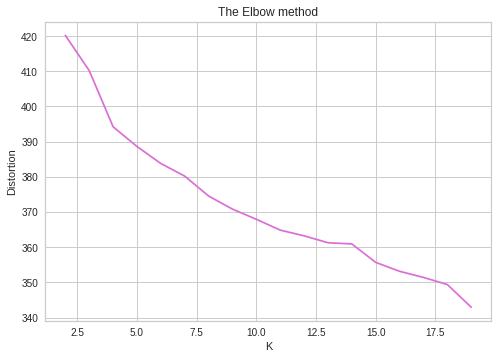

In [504]:
final_dataset = feature_selected_features.merge(feature_selected_tracks, on='track_id')
array = final_dataset.values
cost = [] 

for i in range(2, max_k): 
    clusters, distances = K_Means(array, i, 10)
    
    cost.append(sum(distances**2)/array.shape[0])

x = list(range(2,20)) 

plt.plot(x, cost, color = "orchid")
plt.title("The Elbow method")
plt.xlabel("K")
plt.ylabel("Distortion")
plt.show()


We chosed optimal k as 13.

In [530]:
final_dataset = feature_selected_features.merge(feature_selected_tracks, on='track_id')
array = final_dataset.values
clusters, distances = K_Means(array, 13, 10)

Now you can see the Pivot below.

In [531]:
columns = ['track_duration', 'track_language_code', 'album_listens', 'album_tracks', 'artist_location', 'track_genre_top']
numeric_columns = ['track_duration', 'album_listens', 'album_tracks']
final_dataset = clustering_data['tracks'].\
    merge(clustering_data['features'], on='track_id').set_index('track_id')

pivot = pd.DataFrame(pd.qcut(final_dataset[numeric_columns[0]], q = 4,labels=['A', 'B', 'C', 'D']))
for i in range(1, 3):
    pivot = pivot.merge(pd.qcut(final_dataset[numeric_columns[i]], q = 4,labels=['A', 'B', 'C', 'D']), on='track_id') 
pivot = pivot.merge(final_dataset[columns[1]], on='track_id')
pivot = pivot.merge(final_dataset[columns[-1]], on='track_id')
pivot = pivot.merge(final_dataset[columns[-2]], on='track_id')

pivot['clusters'] = clusters
pivot

,track_duration,album_listens,album_tracks,track_language_code,track_genre_top,artist_location,clusters
track_id,,,,,,,
2,B,B,A,en,Hip-Hop,New Jersey,6
3,C,B,A,en,Hip-Hop,New Jersey,6
5,B,B,A,en,Hip-Hop,New Jersey,6
10,B,D,A,en,Pop,,6
20,D,A,C,en,,Colchester England,9
...,...,...,...,...,...,...,...
155316,B,A,A,,Rock,New Jersey,9
155317,C,A,A,,Rock,New Jersey,9
155318,D,A,A,,Rock,New Jersey,9


In [536]:
duration_pivot = pivot[[columns[5], 'clusters']].reset_index().groupby([columns[5], 'clusters']).count().\
    reset_index().pivot(columns[5], 'clusters', 'track_id')
duration_pivot.index = duration_pivot.index.to_list()

totals = duration_pivot.sum(0)
duration_pivot = duration_pivot.append(pd.DataFrame([totals], index=['total']))
duration_pivot.index.name = columns[5]
100*duration_pivot/totals


clusters,0,1,2,3,4,5,6,7,8,9,10,11,12
track_genre_top,,,,,,,,,,,,,
,61.840000,56.590172,60.955853,84.031710,54.515635,66.972294,43.220637,43.719996,45.828604,52.603177,60.461307,57.499566,52.586125
Blues,0.160000,0.276343,0.121507,0.792752,0.087470,0.159458,0.161664,0.011164,NaN,0.055191,0.013648,0.138720,0.009490
Classical,1.253333,0.672834,0.607533,5.322763,0.211386,1.953359,0.098404,0.055822,NaN,0.208499,0.136482,7.560257,0.028471
Country,0.053333,0.564700,0.081004,0.113250,0.102048,0.099661,0.231953,0.133973,0.085131,0.343411,0.040944,0.104040,0.037961
Easy Listening,0.026667,NaN,0.162009,NaN,0.080181,0.019932,0.007029,NaN,NaN,0.006132,0.027296,0.008670,0.018981
Electronic,4.986667,4.685810,5.791819,2.491506,12.347839,9.886386,7.246784,6.263258,9.591373,3.685534,15.026614,2.713716,23.678466
Experimental,9.893333,7.821699,12.474686,NaN,12.376995,10.145505,13.762564,9.623758,23.325766,5.825719,8.448205,8.461939,8.389485
Folk,8.373333,8.158116,3.888214,0.226501,1.151687,1.355392,1.258171,0.625209,0.624291,2.342552,0.682408,6.771285,0.151846
Hip-Hop,0.720000,0.696864,0.364520,0.453001,6.582112,1.614511,5.609053,1.339734,1.333712,1.281658,4.926982,0.173400,8.683686


For a sample you can see the diifferences between track_genre_top in this section and the previous section.